# Pythonによる画像解析ノート Vol. 6

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

## スタック画像のシフト補正  
タイムラプス画像データのフレーム毎の微妙なズレ（シフト）を補正するのに、ImageJ/FIJIではHyperstackRegプラグインを使用していた：https://github.com/ved-sharma/HyperStackReg  
Pythonにも同等の機能を持つモジュール pystackregが移植されているのでそれを利用する：  
https://pypi.org/project/pystackreg/
https://github.com/bnsreenu/python_for_microscopists/blob/master/121_image_registration_using_pystackreg.py  
https://github.com/bnsreenu/python_for_microscopists/blob/master/121_image_registration_using_pystackreg.py  

pyStackReg provides the following five types of distortion:

- translation
- rigid body (translation + rotation)
- scaled rotation (translation + rotation + scaling)
- affine (translation + rotation + scaling + shearing)
- bilinear (non-linear transformation; does not preserve straight lines)

pyStackReg supports the full functionality of StackReg plus some additional options, e.g., using different reference images and having access to the actual transformation matrices (please see the examples below). Note that pyStackReg uses the high quality (i.e. high accuracy) mode of TurboReg that uses cubic spline interpolation for transformation.

Please note: The bilinear transformation cannot be propagated, as a combination of bilinear transformations does not generally result in a bilinear transformation. Therefore, stack registration/transform functions won't work with bilinear transformation when using "previous" image as reference image. You can either use another reference ("first" or "mean" for first or mean image, respectively), or try to register/transform each image of the stack separately to its respective previous image (and use the already transformed previous image as reference for the next image).

In [7]:
import cv2
from pystackreg import StackReg
from skimage import io
from matplotlib import pyplot as plt

### 1. 単一画像の補正 
基準となる画像（reference image）があり、それに対して動いた画像（moved image）を合わせる場合。

In [8]:
img = cv2.imread("images/monkey.jpg", 0) # グレースケール画像が必要
moved = cv2.imread("images/monkey_moved.jpg", 0)  # シフトかつ回転させた

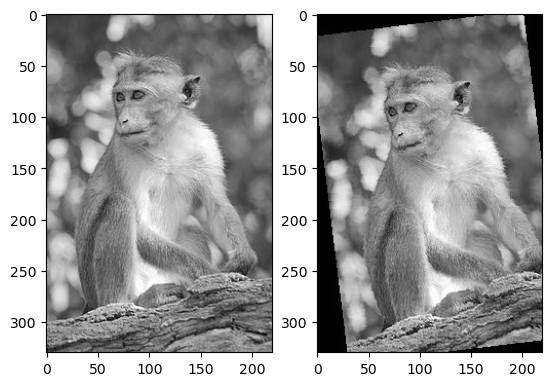

In [10]:
plt.subplot(1,2,1)
plt.imshow(img, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(moved, cmap = "gray")

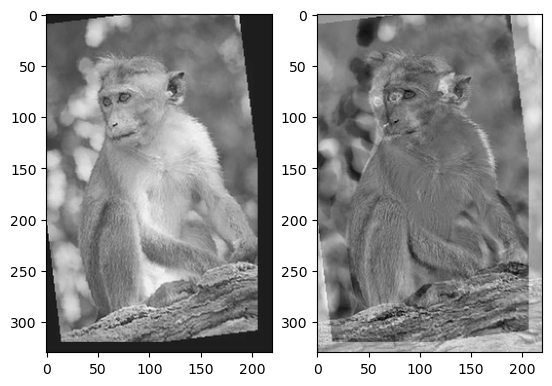

In [15]:
#Translational transformation、回転は補正されない
sr = StackReg(StackReg.TRANSLATION)
out_tra = sr.register_transform(img, moved)
diff = img - out_tra
plt.subplot(1,2,1)
plt.imshow(out_tra, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(diff, cmap = "gray")

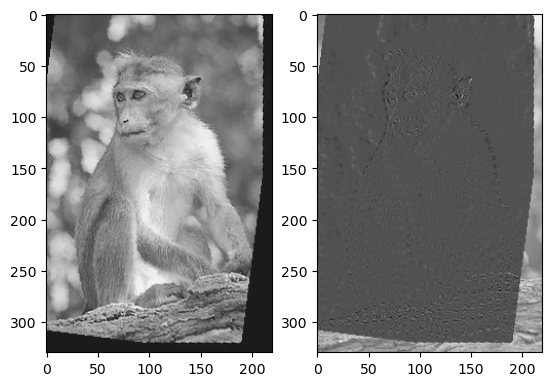

In [17]:
#Rigid Body transformation、ほぼ補正される
sr = StackReg(StackReg.RIGID_BODY)
out_rot = sr.register_transform(img, moved)
diff = img - out_rot
plt.subplot(1,2,1)
plt.imshow(out_rot, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(diff, cmap = "gray")

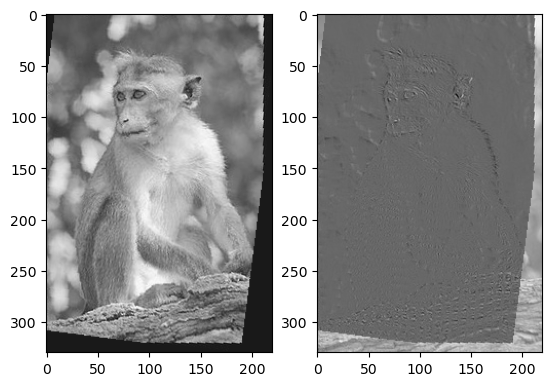

In [19]:
# Scaled Rotation transformation
sr = StackReg(StackReg.SCALED_ROTATION)
out_sca = sr.register_transform(img, moved)
diff = img - out_sca
plt.subplot(1,2,1)
plt.imshow(out_sca, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(diff, cmap = "gray")

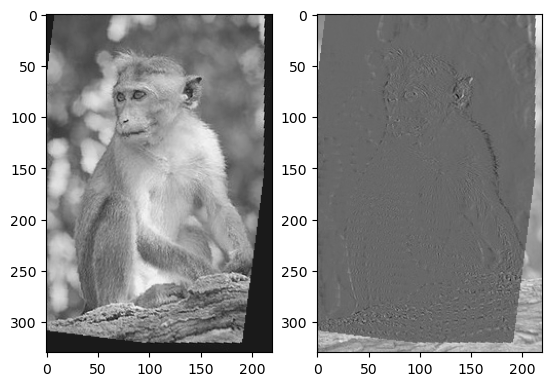

In [20]:
#Affine transformation
sr = StackReg(StackReg.AFFINE)
out_aff = sr.register_transform(img, moved)
diff = img - out_aff
plt.subplot(1,2,1)
plt.imshow(out_aff, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(diff, cmap = "gray")

### 2. スタック画像の補正  
研究においてはタイムラプス画像のスタックを`rigid body (シフト+回転)`で補正することが多い。  
アフィン変換だと画像の大きさが変化してしまうので科学研究のデータにおいてはNGな操作。  
元々のStackRegでは各フレームを一つ前のフレームに合わせていたが、pystackregではその他にも色々なオプションがある。

#### 2-1. 単一チャンネルスタック画像の補正  
"yeast_tl.tif"では細胞が少しずつ左にシフトしているので補正する。

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


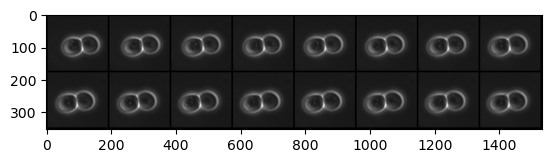

In [27]:
from tifffile import tifffile as tiff
from skimage.util import montage
img0 = tiff.imread("images/yeast_tl.tif")
mon = montage(img0, fill = 0, grid_shape=(2, 8), padding_width=5) # pading_widthは隙間、fillは隙間の明るさ
plt.imshow(mon, cmap = "gray")

In [59]:
# モンタージュを表示するための関数
def show_mon(img):
    mon = montage(img, fill = 0, grid_shape=(2, 8), padding_width=5) # pading_widthは隙間、fillは隙間の明るさ
    plt.imshow(mon, cmap = "gray")

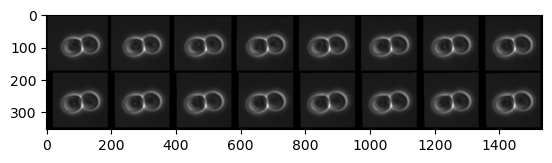

In [60]:
sr = StackReg(StackReg.RIGID_BODY)
# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
out_previous = sr.register_transform_stack(img0, reference='previous')
show_mon(out_previous)

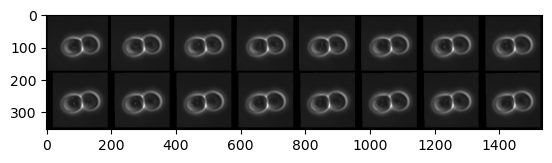

In [61]:
# register to first image
out_first = sr.register_transform_stack(img0, reference='first')
show_mon(out_first)

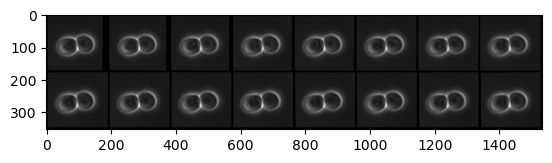

In [62]:
# register to mean image
out_mean = sr.register_transform_stack(img0, reference='mean')
show_mon(out_mean)

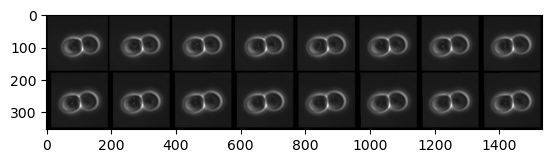

In [63]:
# register to mean of first 3 images
out_first3 = sr.register_transform_stack(img0, reference='first', n_frames=3)
show_mon(out_first3)

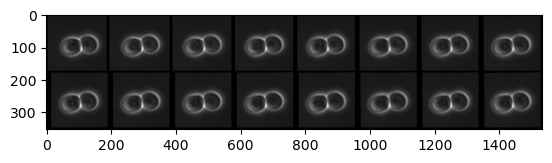

In [64]:
# calculate a moving average of 3 images, then register the moving average to the mean of
# the first 3 images and transform the original image (not the moving average)
out_moving3 = sr.register_transform_stack(img0, reference='first', n_frames=3, moving_average = 3)
show_mon(out_moving3)

#### 2-2. マルチチャンネルスタック画像の補正  
あるチャンネルの画像でシフトを補正して、それと同じように別の画像もシフトを補正する場合。

uint16


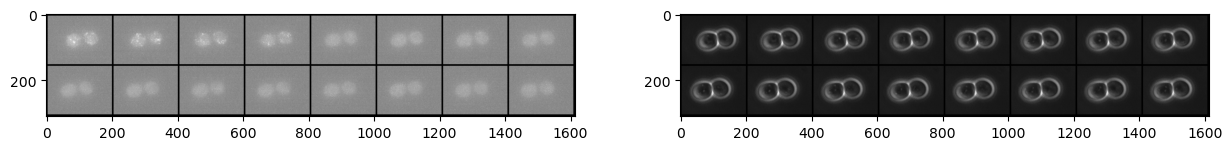

In [78]:
img1 = tiff.imread("images/yeast_2ch.tif")
img1_c1 = img1[:,0,:,:] # Ch1 image: 緑蛍光
img1_c2 = img1[:,1,:,:] # Ch2 image: 位相差
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
show_mon(img1_c1)
plt.subplot(1,2,2)
show_mon(img1_c2)
print(img1.dtype)

In [79]:
# Ch2の位相差像で補正して、それをCh1のスタックに適用したい
sr = StackReg(StackReg.RIGID_BODY)

# tmatsは補正に関する行列、tmatsを出力すると同時にインスタンスsrその情報が登録される
tmats = sr.register_stack(img1_c2, reference='previous') # この時点ではimg1_c2そのものは変換されない
out_c1 = sr.transform_stack(img1_c1) # tmatsに従ってimg1_c1を変換
out_c2 = sr.transform_stack(img1_c2) # timatsに従ってimg1_c2を変換

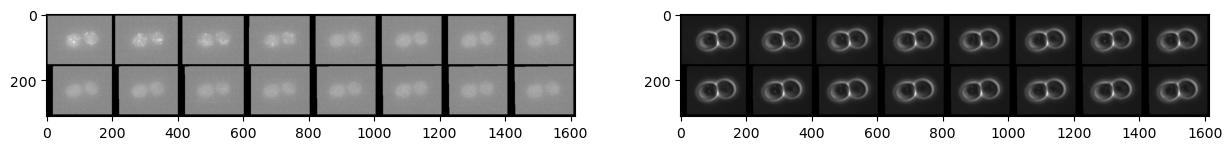

In [80]:
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
show_mon(out_c1)
plt.subplot(1,2,2)
show_mon(out_c2)

In [81]:
# 補正したスタックからhyperstackファイルを作成して保存
# メタデータを読み込んでおく
with tiff.TiffFile("images/yeast_2ch.tif") as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:",f.filename)
    print("各次元の説明:", f.series[0].axes)
    tags = f.pages[0].tags
    ijmetadata = f.imagej_metadata
# Voxel sizeとResolutionはimagej_metadataとtagsの情報から計算できる
# 複数のZスライスが含まれる場合はZResolutionも考慮に入れる
lengthunit = ijmetadata["unit"]
xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
print("Unit of length:", lengthunit)
print(f"Resolution in X: {xresolution} pixels per {lengthunit}")
print(f"Resolution in Y: {yresolution} pixels per {lengthunit}")
print(f"Voxel size: {1/xresolution} x {1/yresolution} x 1 {lengthunit}^3")

ファイル名: yeast_2ch.tif
各次元の説明: TCYX
Unit of length: micron
Resolution in X: 11.361111 pixels per micron
Resolution in Y: 11.361111 pixels per micron
Voxel size: 0.0880195607630275 x 0.0880195607630275 x 1 micron^3


In [83]:
# img1と同じshapeのブランクのndarrayを作成、(frames, ch, y, x)
fr, ch, y, x = img1.shape
img1_regi = np.zeros((fr, ch, y, x)).astype("uint16")

img1_regi[:, 0, :, :] = out_c1
img1_regi[:, 1, :, :] = out_c2

# tiff.imwriteでメタデータと一緒に保存、metadataには読み込んだ辞書形式のデータをそのまま指定すれば良い
tiff.imwrite('images/yeast_2ch_regi.tif', img1_regi,
     imagej = True,
     resolution = (xresolution, yresolution),
     metadata = ijmetadata)
    # {
        # 'spacing': 3.947368,
         # 'unit': 'um',
         # 'finterval': 1/10,
         # 'fps': 10.0,
       # 'axes': 'TCYX',
         # 'Labels': image_labels,
             # })

In [ ]:
# tmatsを保存しておいて、ロードして使用することができる
import numpy as np
np.save('transformation_matrices.npy', tmats)

tmats_loaded = np.load('transformation_matrices.npy')

# make sure you use the correct transformation here!
sr = StackReg(StackReg.RIGID_BODY)

# transform stack using the tmats loaded from file
sr.transform_stack(img1, tmats=tmats_loaded)

# with the transformation matrices at hand you can also
# use the transformation algorithms from other packages:
from skimage import transform as tf

out = np.zeros(img0.shape).astype(np.float)

for i in range(tmats.shape[0]):
    out[i, :, :] = tf.warp(img1[i, :, :], tmats[i, :, :], order=3)